In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from preprocessing import read_folder


# Обработка данных

In [354]:
raw_data = pd.read_excel("./data/data_merged_new.xlsx", index_col=0)

In [350]:
raw_data

,IDcard,AGE,SEX,GROUP,PARKINSON,STAGE,PD_duration (years),курение,АГ,СД,...,803.694275,805.66482,807.635943,809.607641,811.579916,813.552766,815.526191,817.500191,819.474764,821.44991
0,CG1,NaN,male,Control,NO,Control,NaN,NaN,NaN,NaN,...,41,34,28,38,29,35,37,33,29,29
1,CG1,NaN,male,Control,NO,Control,NaN,NaN,NaN,NaN,...,32,33,31,39,25,30,21,16,31,22
2,CG1,NaN,male,Control,NO,Control,NaN,NaN,NaN,NaN,...,21,24,25,28,32,23,16,23,20,19
3,CG1,NaN,male,Control,NO,Control,NaN,NaN,NaN,NaN,...,33,18,22,25,18,17,36,22,24,25
4,CG1,NaN,male,Control,NO,Control,NaN,NaN,NaN,NaN,...,27,22,16,19,15,21,24,30,22,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,КОНТРОЛЬ-4(П),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49,44,45,34,38,27,34,31,33,38
1020,КОНТРОЛЬ-4(П),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,40,37,36,38,33,26,21,28,30,25
1021,КОНТРОЛЬ-4(П),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,41,30,42,32,35,34,60,34,30,23
1022,КОНТРОЛЬ-4(П),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,36,40,34,39,34,42,31,28,38,41


In [339]:
path = ".\\raw_data\\comparison_group\\SD"
data_sd = read_folder(path)
data_sd.reset_index(inplace=True)

Reading file: MG152 (Л).txt.....

File MG152 (Л).txt has been read correctly
Reading file: MG152 (П).txt.....

File MG152 (П).txt has been read correctly
Reading file: SD001 (Л).txt.....

File SD001 (Л).txt has been read correctly
Reading file: SD001 (П).txt.....

File SD001 (П).txt has been read correctly


In [340]:
path = ".\\raw_data\\parkinson_group\\parkinson_diabetes"
data_park = read_folder(path)
data_park.reset_index(inplace=True)

Reading file: MG151(Л).txt.....

File MG151(Л).txt has been read correctly
Reading file: MG151(П).txt.....

File MG151(П).txt has been read correctly
Reading file: MG153(Л).txt.....

File MG153(Л).txt has been read correctly


In [341]:
data_park['index'] = data_park['index'].apply(lambda x: x[:-4])
data_park.rename(columns={"index": "IDcard"})
data_park.set_index("index", inplace=True)
data_park['GROUP'] = "Parkinson + diabetes"
data_park['СД'] = "да"

In [342]:
data_sd['index'] = data_sd['index'].apply(lambda x: x[:-4])
data_sd.rename(columns={"index": "IDcard"})
data_sd.set_index("index", inplace=True)
data_sd['GROUP'] = "Comparison"
data_sd['СД'] = "да"

In [ ]:
ids_with_diabetes = ["БП020(П)", "БП020(Л)", "БП030(П)", "БП030(Л)"]
raw_data.loc[raw_data["IDcard"].isin(ids_with_diabetes), "СД"] = "да"

In [366]:
raw_data = raw_data[['IDcard', 'GROUP', 'СД'] + list(raw_data.columns[-221:])]
raw_data.set_index("IDcard", inplace=True)

In [367]:
raw_data_new = pd.concat([raw_data, data_park, data_sd])
raw_data_new.reset_index(inplace=True)
raw_data_new.rename(columns={"index":"IDcard"}, inplace=True)
raw_data_new.set_index("IDcard", inplace=True)

In [187]:
def delete_hot_pixels(arr: list, q: float=0.9,
                      window: int = 3) -> list:
    delta = pd.Series(np.array([]))
    for i in range(1, len(arr) - 1):
        x1 = arr[i-1]
        x2 = arr[i]
        x3 = arr[i+1]
        delta[i] = (x2-x1)*(x3-x2)
    q_value = delta.quantile(1-q)
    filtered_arr = [arr[0]]
    for i in range(1, len(arr)-1):
        if delta[i] <= q_value:
            filtered_arr.append(
                sum(arr[i-window//2:i] +\
                    arr[i+1:i+window//2+1]) / (window-1)
                )
        else:
            filtered_arr.append(arr[i])
    filtered_arr.append(arr[-1])
    return filtered_arr

In [372]:
pd.set_option('display.max_columns', 20)
df = raw_data_new.copy()

group = []
for x in df.loc["БП008(Л)":].index:
    if "БП" in x:
        if  df.loc[x].sample(1).loc[x, "СД"] == 'да':
            group.append("Parkinson + Diabetes")
        else:
            group.append("Parkinson")
    elif "MG" in x and ("MG" in x and df.loc[x].sample(1).loc[x, "GROUP"] == 'Parkinson + diabetes'):
        group.append("Parkinson + Diabetes")
    elif "SD" in x or ("MG" in x and df.loc[x].sample(1).loc[x, "GROUP"] != 'Parkinson + diabetes'):
        group.append("Comparison")
    else:
        group.append("Control")
group = df.dropna(subset=["GROUP"])["GROUP"].to_list()[:-data_sd.shape[0] - data_park.shape[0]] + group
df["GROUP"] = group
df.reset_index(inplace=True)
df["level_3"] =  [x + f"_{i % 8 + 1}" for i, x in enumerate(df["IDcard"])]
df.set_index(["GROUP", "IDcard", "level_3", "СД"], inplace=True)
df_1 = df.loc[:, 401.733364293274:]

df_1.rename(axis=1,
          mapper=lambda x: f"{int(x)}",
          inplace=True)

In [388]:
df_1.reset_index(level="СД", inplace=True)
df_1.loc[df_1.index.get_level_values(level="IDcard").str.contains("CG"), "СД"] = "нет"
df_1.set_index("СД", append=True, inplace=True)
df_1 = df_1.reset_index(level=3).dropna().set_index("СД", append=True)
df_1.drop(index=["MG151(Л)", "MG151(П)"], level=1, inplace=True)

In [389]:
df_raw = df_1.copy()
df_raw.drop(index=df_raw.loc[(df_raw.index.get_level_values(level="СД") == "нет") & (df_raw.index.get_level_values(level="GROUP") == "Comparison")].index, inplace=True)
df_raw = df_raw.astype("float32")
for index in df_raw.index:
    df_raw.loc[index, df_raw.columns[:-70]] = delete_hot_pixels(df_raw.loc[index, df_raw.columns[:-70]].to_list(), q=0.95, window=7)


In [390]:
from scipy.signal import savgol_filter

def smooth(data: pd.DataFrame, window_length:int=7, polyorder:int=3) -> pd.DataFrame:
    data_sm = None
    for y in data.to_numpy():
        y_smooth = savgol_filter(y, window_length, polyorder)
        if data_sm is None:
            data_sm = y_smooth
        else:
            data_sm = np.vstack((data_sm, y_smooth))
    df_sm = pd.DataFrame(data_sm, index=data.index, columns=data.columns)
    return df_sm

In [391]:
df_raw_1 = df_raw.copy()
df_raw_1[df_raw_1.columns[:-70]] = smooth(df_raw_1[df_raw_1.columns[:-70]], 7)


In [392]:
df_raw = df_raw_1.copy()
hand = ["left" if x[:-3] == "(Л)" else "right" for x in df_raw.index.get_level_values(level="IDcard")]
df_raw["hand"] = hand
df_raw.reset_index(inplace=True)
df_raw["IDcard"] = df_raw["IDcard"].apply(lambda x: x[:-3] if x[-3] == "(" else x)
df_raw.set_index(["GROUP", "IDcard", "hand", "level_3"], inplace=True)

In [393]:
df_raw.set_index("СД", append=True, inplace=True)
df_raw.reset_index(level="GROUP", inplace=True)
df_raw["GROUP"] = df_raw["GROUP"].apply(lambda x: "Diabetes" if x == "Comparison" else x)
df_raw.set_index("GROUP", append=True, inplace=True)

In [394]:
from typing import Union
def d_norm(data: Union[pd.Series, pd.DataFrame],
                laser_wave_left: float = 731.195121105382,
                laser_wave_right: float = 772.244519389919,
                cutoff_wave: float = 676.874469938485):
    if isinstance(data, pd.Series):
        data = data.loc[:cutoff_wave].div(
            data.loc[laser_wave_left:laser_wave_right].mean())
    else:
        data = data.loc[:, :cutoff_wave].div(
            data.loc[:, laser_wave_left:laser_wave_right].mean(axis=1),
            axis=0)
        data.rename(axis=1,
                    mapper=lambda x: f"D{int(x)}",
                    inplace=True)
    return data

In [451]:
df_dnorm = d_norm(df_raw.copy(), "731", "772", "676")
df_dnorm.loc[df_dnorm.index.get_level_values("GROUP").isin(["Parkinson + Diabetes", "Diabetes"]), df_dnorm.columns[80:100]] = smooth(
    df_dnorm.loc[df_dnorm.index.get_level_values("GROUP").isin(["Parkinson + Diabetes", "Diabetes"]), df_dnorm.columns[80:100]], 
    window_length=9,
    polyorder=3
)

In [452]:
from sklearn.linear_model import LinearRegression
def i_norm(data_dnorm: pd.DataFrame) -> pd.DataFrame:
    data_Inorm_arr = []
    reg = LinearRegression()
    for group in data_dnorm.index.get_level_values("GROUP").unique():
        data_buf = data_dnorm[
            data_dnorm.index.get_level_values("GROUP").isin([group])
            ]
        mean_values = data_buf.mean().to_numpy().reshape(-1, 1)
        for i in range(len(data_buf)):
            x = np.array(
                list(data_buf.iloc[i])
                ).reshape(-1, 1)
            reg.fit(mean_values, x)
            A, B = reg.coef_[0][0], reg.intercept_[0]
            x = (x - B) / A
            data_Inorm_arr.append(x.reshape(-1,))

    data_Inorm = np.asarray(data_Inorm_arr)
    data_Inorm = pd.DataFrame(data_Inorm,
                              columns=data_dnorm.keys(),
                              index=data_dnorm.index
                            )

    data_Inorm.columns = [f"I{i[1:]}" if i[0] == "D" 
                          else f"I{i}" 
                          for i in data_Inorm.keys()]
    return data_Inorm

In [453]:
df_inorm = i_norm(df_dnorm)

# Статистический анализ

## Отрисовка исходных графиков 

In [147]:
def sigma(x, mean):
    N = len(mean)
    return (np.sum((x - mean) ** 2, axis=0) / N) ** 0.5

def draw_spectra_with_error(data, start="I401", stop="I676", style="seaborn-v0_8-deep", title="I-нормировка", errors=True):

    df = data.copy()
    cont_mean = df.loc[df.index.get_level_values(level="GROUP") == "Control", start:stop].mean(axis=0).to_numpy()
    park_mean = df.loc[df.index.get_level_values(level="GROUP") == "Parkinson", start:stop].mean(axis=0).to_numpy()
    comp_mean = df.loc[df.index.get_level_values(level="GROUP") == "Diabetes", start:stop].mean(axis=0).to_numpy()

    sigma_cont = sigma(df.loc[df.index.get_level_values(level="GROUP") == "Control", start:stop].to_numpy(), cont_mean)
    sigma_park = sigma(df.loc[df.index.get_level_values(level="GROUP") == "Parkinson", start:stop].to_numpy(), park_mean)
    sigma_comp = sigma(df.loc[df.index.get_level_values(level="GROUP") == "Diabetes", start:stop].to_numpy(), comp_mean)
    # Настройка стиля
    plt.style.use(style)
    sns.set_palette("coolwarm")
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 7))

    # Предполагаем, что у вас есть временная ось (например, x = np.arange(len(cont_mean)))
    x = [int(x[1:]) if x[0] in ["D", "I"] else int(x) for x in df.loc[:, start:stop].columns]
    
    # Построение всех трех кривых с погрешностями
    plt.errorbar(x, cont_mean, fmt='-o', 
                color='#1f77b4', ecolor='#1f77b4', alpha=0.8,
                label='Контроль', capsize=4, elinewidth=1.5)

    plt.errorbar(x, park_mean, fmt='-s', 
                color='#d62728', ecolor='#d62728', alpha=0.8,
                label='Паркинсон', capsize=4, elinewidth=1.5)

    plt.errorbar(x, comp_mean, fmt='-^', 
                color='#2ca02c', ecolor='#2ca02c', alpha=0.8,
                label='Диабет', capsize=4, elinewidth=1.5)
    if errors == True:
        plt.fill_between(x, cont_mean - sigma_cont, cont_mean + sigma_cont, 
                        color='#1f77b4', alpha=0.2)
        plt.fill_between(x, park_mean - sigma_park, park_mean + sigma_park, 
                        color='#d62728', alpha=0.2)
        plt.fill_between(x, comp_mean - sigma_comp, comp_mean + sigma_comp, 
                        color='#2ca02c', alpha=0.2)
    # Дополнительное оформление

    plt.xlabel('Длина волны, нм', fontsize=14)
    plt.ylabel('Интенсивность, отн. ед.', fontsize=14)
    plt.title(title, fontsize=16, pad=20)
    plt.legend(fontsize=12, framealpha=1)

    # Настройка сетки и осей

    plt.grid(False, linestyle='--', alpha=0.5)
    sns.despine()

    # Автоматическое масштабирование осей с запасом для погрешностей

#     ymin = min(np.min(cont_mean - sigma_cont), 
#             np.min(park_mean - sigma_park), 
#             np.min(comp_mean - sigma_comp)) - 0.1
#     ymax = max(np.max(cont_mean + sigma_cont), 
#             np.max(park_mean + sigma_park), 
#             np.max(comp_mean + sigma_comp)) + 0.1
#     plt.ylim(ymin, ymax)

    plt.tight_layout()
    plt.show()

C:\Users\nikba\AppData\Local\Temp\ipykernel_2748\1989601512.py:52: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(False, linestyle='--', alpha=0.5)


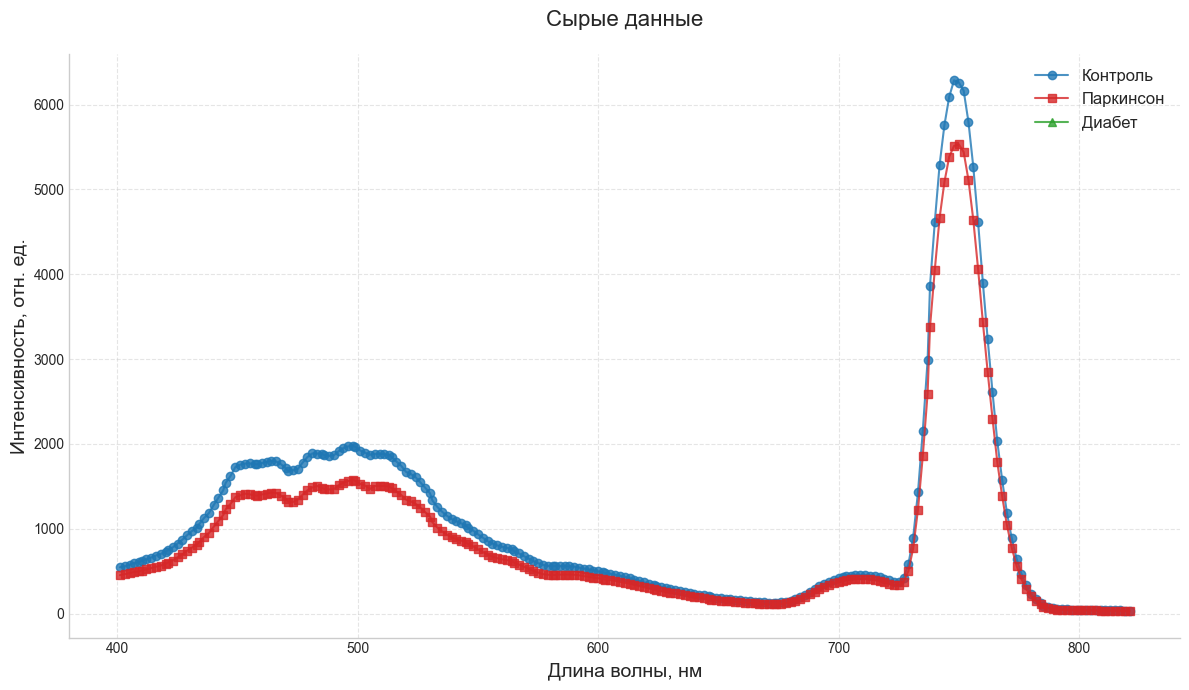

In [189]:
draw_spectra_with_error(df_raw, start="401", stop="821", style="seaborn-v0_8-whitegrid", title="Сырые данные", errors=False)

In [215]:
df_dnorm.drop(index="MG151", level=0, inplace=True)

In [225]:
df_raw.drop(index="MG151", level=0, inplace=True)

<>:22: SyntaxWarning: invalid escape sequence '\d'
<>:22: SyntaxWarning: invalid escape sequence '\d'
C:\Users\nikba\AppData\Local\Temp\ipykernel_2748\3444046364.py:22: SyntaxWarning: invalid escape sequence '\d'
  data_long['Wavelength'] = data_long['Wavelength'].str.extract('(\d+)').astype(int)
C:\Users\nikba\AppData\Local\Temp\ipykernel_2748\3444046364.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Spectral Range'] = data_filtered['Spectral Range'].cat.remove_categories(['480-520', '570-580'])
C:\Users\nikba\AppData\Local\Temp\ipykernel_2748\3444046364.py:38: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update 

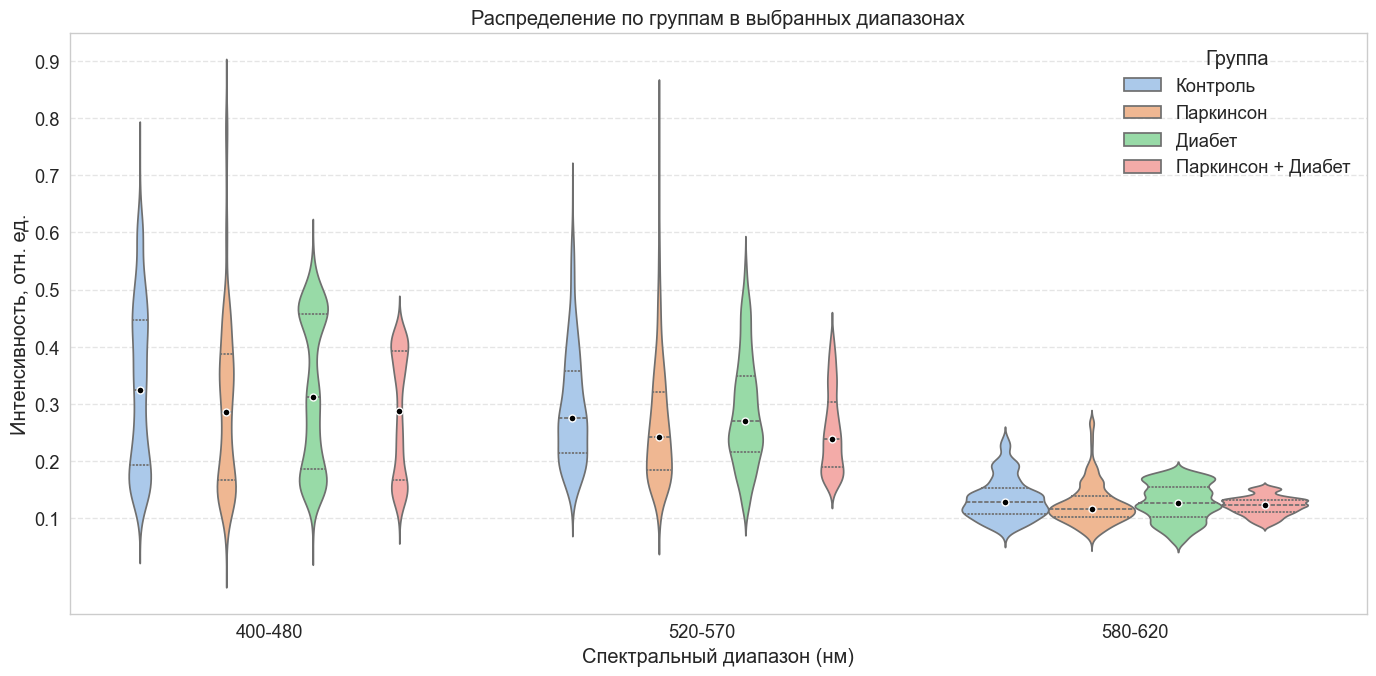

In [493]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def fun(x):
    if x == "Control":
        return "Контроль"
    elif x == "Parkinson":
        return "Паркинсон"
    elif x == "Parkinson + Diabetes":
        return "Паркинсон + Диабет"
    else:
        return "Диабет"

# Подготовка данных
data = df_dnorm.reset_index(level="GROUP")
data['GROUP'] = data['GROUP'].apply(fun)

# Преобразуем в "длинный" формат
data_long = pd.melt(data, id_vars=['GROUP'], var_name='Wavelength', value_name='Intensity')
data_long['Wavelength'] = data_long['Wavelength'].str.extract('(\d+)').astype(int)

# Разбиваем на диапазоны (исправленный вариант)
bins = [400, 480, 520, 570, 580, 620]  # Правильные границы для ваших selected_ranges
labels = ['400-480', '480-520', '520-570', '570-580', '580-620']
data_long['Spectral Range'] = pd.cut(data_long['Wavelength'], bins=bins, labels=labels, right=False)

selected_ranges = ['400-480', '520-570', '580-620']

data_filtered = data_long[data_long['Spectral Range'].isin(selected_ranges)]
data_filtered['Spectral Range'] = data_filtered['Spectral Range'].cat.remove_categories(['480-520', '570-580'])
# Создаем фигуру
# 3. Ручной расчет и отрисовка медиан (корректный способ)
plt.figure(figsize=(14, 7))

# Сначала создаем violin plot
ax = sns.violinplot(
    data=data_filtered,
    x='Spectral Range',
    y='Intensity',
    hue='GROUP',
    split=False,
    inner='quartile',
    palette='pastel',
    bw=0.2,
    zorder=1  # Нижний слой
)


### Ключевая правка: Ручное вычисление и отрисовка медиан ###
# Получаем текущие позиции групп на оси X
n_groups = len(data_filtered['GROUP'].unique())
n_ranges = len(data_filtered['Spectral Range'].unique())

# Сдвиг для dodging (как в violinplot)
dodge_width = 0.8 / n_groups  # Эмпирическая формула, аналогичная seaborn

for i, spectral_range in enumerate(data_filtered['Spectral Range'].unique()):
    for j, group in enumerate(data_filtered['GROUP'].unique()):
        # Фильтруем данные для текущей группы и диапазона
        subset = data_filtered[
            (data_filtered['Spectral Range'] == spectral_range) & 
            (data_filtered['GROUP'] == group)
        ]
        
        # Вычисляем медиану
        median_val = subset['Intensity'].median()
        
        # Рассчитываем позицию X с учетом dodging
        x_pos = i + (j - (n_groups-1)/2) * dodge_width
        
        # Рисуем точку медианы
        ax.plot(
            x_pos, 
            median_val, 
            marker='o', 
            markersize=5,
            color='black',
            markeredgewidth=1,
            markeredgecolor='white'
        )

# Финал оформления
plt.title('Распределение по группам в выбранных диапазонах')
plt.xlabel('Спектральный диапазон (нм)')
plt.ylabel('Интенсивность, отн. ед.')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[:n_groups], labels[:n_groups], title='Группа')
plt.tight_layout()
plt.show()


# Фикс легенды (если дублируется)
# handles, labels = plt.gca().get_legend_handles_labels()
# unique_labels = dict(zip(labels, handles))  # Удаляем дубли
# plt.legend(unique_labels.values(), unique_labels.keys(), title='Группа')

# plt.tight_layout()
# plt.show()

In [217]:
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, Optional, Union, List

def plot_fluorescence_spectra(
    data: pd.DataFrame,
    x_col: str = 'wavelength',
    y_col: str = 'intensity',
    group_col: str = 'GROUP',
    groups: Optional[Dict[str, str]] = None,
    style: str = 'whitegrid',
    palette: Union[str, List[str], Dict[str, str]] = 'coolwarm',
    figsize: tuple = (12, 6),
    title: str = 'Средние спектры аутофлуоресценции кожи',
    xlabel: str = 'Длина волны (нм)',
    ylabel: str = 'Интенсивность (отн. ед.)',
    ci: int = 95,
    estimator: str = 'mean',
    rotation: int = 45,
    grid_alpha: float = 0.3,
    legend_title: str = 'Группы',
    line_styles: Optional[Dict[str, tuple]] = None,  # Изменено на tuple
    line_width: int = 2,
    font_scale: float = 1.2,
    context: str = 'notebook',
    save_path: Optional[str] = None,
    **kwargs
):
    """
    Построение спектров аутофлуоресценции с настройкой стилей.
    
    Параметры:
    ----------
    line_styles : dict, optional
        Стили линий для групп в формате {'group_name': (on, off)}
        Например: {'Control': (2, 1), 'Diabetes': (4, 1)}
    """
    # Настройка стилей
    plt.style.use("seaborn-v0_8")
    sns.set_style(style)
    sns.set_context(context, font_scale=font_scale)
    
    if isinstance(palette, str) and groups:
        palette = list(groups.values())
    
    # Создание фигуры
    plt.figure(figsize=figsize)
    
    # Подготовка параметров стиля линий
    style_params = {}
    if line_styles:
        style_params['style'] = group_col
        style_params['dashes'] = line_styles
    
    # Построение графиков
    lineplot = sns.lineplot(
        data=data,
        x=x_col,
        y=y_col,
        hue=group_col,
        errorbar=('ci', ci),
        estimator=estimator,
        palette=palette,
        linewidth=line_width,
        **style_params,
        **kwargs
    )
    
    # Настройка оформления
    plt.title(title, pad=20)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation)
    plt.grid(alpha=grid_alpha)
    
    # Настройка легенды
    handles, labels = lineplot.get_legend_handles_labels()
    plt.legend(
        title=legend_title,
        handles=handles,
        labels=labels,
        frameon=True,
        framealpha=0.8
    )
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.tight_layout()
    plt.show()




In [436]:
func = lambda x: int(x[1:]) if x[0] in ["D", "I"] else int(x)
df_err = df_raw.reset_index(level="GROUP").melt(id_vars='GROUP', var_name='wavelength', value_name='intensity')
df_err['wavelength'] = df_err['wavelength'].apply(func)

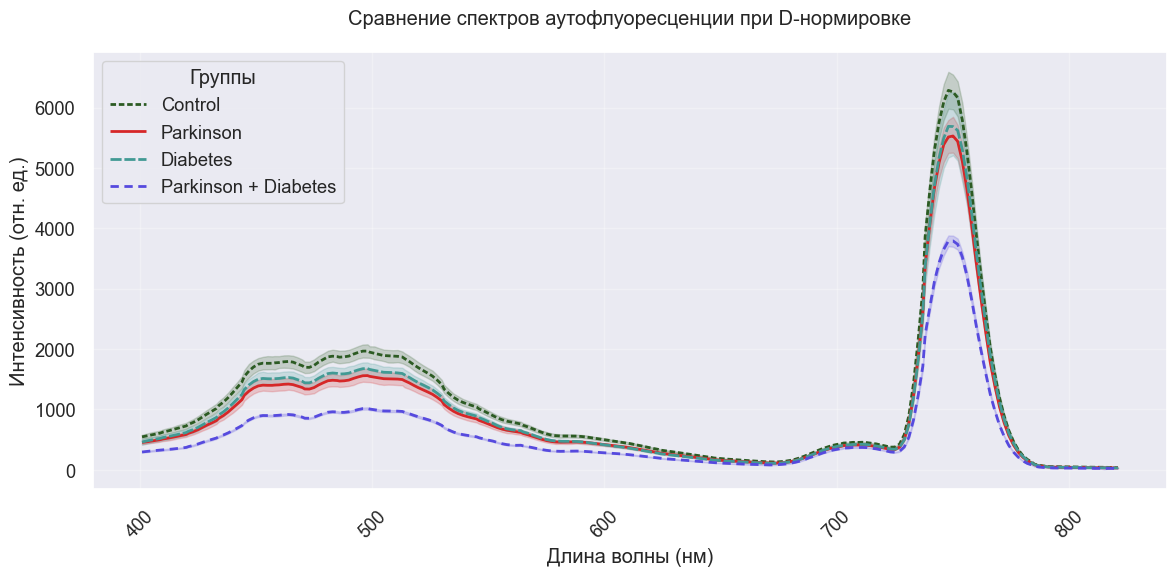

In [ ]:
plot_fluorescence_spectra(
    data=df_err,
    groups={'Control': "#2c5b23", 'Diabetes': '#d62728', 'Parkinson': "#429a94", "Parkinson + Diabetes": "#564ade"},
    line_styles={'Control': (2, 1), 'Diabetes': (4, 1), 'Parkinson': (1, 0), "Parkinson + Diabetes": (3, 2)},
    line_width=2,
    title='Сравнение спектров аутофлуоресценции при D-нормировке',
    ci=98,
    style ='darkgrid',
    palette = 'coolwarm',
)

In [294]:
df_dnorm.loc[df_dnorm.index.get_level_values(level="GROUP") == "Parkinson + Diabetes"]

D401      D403      D405  \
IDcard hand  level_3    СД GROUP                                                
MG153  right MG153(Л)_1 да Parkinson + Diabetes  0.120563  0.129499  0.134925   
             MG153(Л)_2 да Parkinson + Diabetes  0.125559  0.132284  0.137362   
             MG153(Л)_3 да Parkinson + Diabetes  0.134083  0.133262  0.134651   
             MG153(Л)_4 да Parkinson + Diabetes  0.126593  0.128964  0.131246   
             MG153(Л)_5 да Parkinson + Diabetes  0.128972  0.132748  0.134959   
             MG153(Л)_6 да Parkinson + Diabetes  0.130104  0.130840  0.133297   
             MG153(Л)_7 да Parkinson + Diabetes  0.123522  0.132790  0.136927   
             MG153(Л)_8 да Parkinson + Diabetes  0.121485  0.126318  0.131482   

                                                     D407      D409      D410  \
IDcard hand  level_3    СД GROUP                                                
MG153  right MG153(Л)_1 да Parkinson + Diabetes  0.138153  0.141357  0.143170   
             MG153(Л)_2 да Parkinson + Diabetes  0.141187  0.144031  0.146513   
             MG153(Л)_3 да Parkinson + Diabetes  0.137588  0.140703  0.146217   
             MG153(Л)_4 да Parkinson + Diabetes  0.133751  0.137017  0.141671   
             MG153(Л)_5 да Parkinson + Diabetes  0.136410  0.138229  0.140716   
             MG153(Л)_6 да Parkinson + Diabetes  0.136810  0.140371  0.143695   
             MG153(Л)_7 да Parkinson + Diabetes  0.137979  0.137979  0.140060   
             MG153(Л)_8 да Parkinson + Diabetes  0.136179  0.138322  0.140397   

                                                     D412      D414      D416  \
IDcard hand  level_3    СД GROUP                                                
MG153  right MG153(Л)_1 да Parkinson + Diabetes  0.146459  0.150122  0.154367   
             MG153(Л)_2 да Parkinson + Diabetes  0.149966  0.155179  0.159874   
             MG153(Л)_3 да Parkinson + Diabetes  0.150342  0.154720  0.159140   
             MG153(Л)_4 да Parkinson + Diabetes  0.144914  0.150708  0.156591   
             MG153(Л)_5 да Parkinson + Diabetes  0.145045  0.150870  0.156788   
             MG153(Л)_6 да Parkinson + Diabetes  0.147754  0.151861  0.154591   
             MG153(Л)_7 да Parkinson + Diabetes  0.145506  0.150157  0.155557   
             MG153(Л)_8 да Parkinson + Diabetes  0.142814  0.146598  0.150976   

                                                     D418  ...      D659  \
IDcard hand  level_3    СД GROUP                           ...             
MG153  right MG153(Л)_1 да Parkinson + Diabetes  0.159674  ...  0.044305   
             MG153(Л)_2 да Parkinson + Diabetes  0.165651  ...  0.039652   
             MG153(Л)_3 да Parkinson + Diabetes  0.162950  ...  0.037970   
             MG153(Л)_4 да Parkinson + Diabetes  0.161692  ...  0.039976   
             MG153(Л)_5 да Parkinson + Diabetes  0.161486  ...  0.039329   
             MG153(Л)_6 да Parkinson + Diabetes  0.158935  ...  0.041639   
             MG153(Л)_7 да Parkinson + Diabetes  0.158525  ...  0.037820   
             MG153(Л)_8 да Parkinson + Diabetes  0.156219  ...  0.038918   

                                                     D661      D663      D665  \
IDcard hand  level_3    СД GROUP                                                
MG153  right MG153(Л)_1 да Parkinson + Diabetes  0.042905  0.040978  0.039922   
             MG153(Л)_2 да Parkinson + Diabetes  0.038614  0.038073  0.036245   
             MG153(Л)_3 да Parkinson + Diabetes  0.036665  0.036223  0.034581   
             MG153(Л)_4 да Parkinson + Diabetes  0.037985  0.036642  0.035636   
             MG153(Л)_5 да Parkinson + Diabetes  0.041264  0.040734  0.038155   
             MG153(Л)_6 да Parkinson + Diabetes  0.040737  0.038125  0.036844   
             MG153(Л)_7 да Parkinson + Diabetes  0.037235  0.036254  0.034836   
             MG153(Л)_8 да Parkinson + Diabetes  0.039169  0.038325  0.036159   

                                                

In [116]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [98]:
def plot_intensity_histograms(data: pd.DataFrame, 
                             wave_list: list,
                             bins: int = 30,
                             figsize: tuple = (14, 8),
                             palette: str = "viridis",
                             kde: bool = True,
                             stat: str = "density",
                             common_norm: bool = False) -> None:
    """
    Строит гистограммы распределения интенсивностей для заданных длин волн.
    
    Параметры:
    ----------
    data : pd.DataFrame
        DataFrame с спектральными данными (столбцы - длины волн, строки - измерения)
    wave_list : List[float]
        Список длин волн для анализа
    bins : int, optional
        Количество бинов в гистограмме (по умолчанию 30)
    figsize : tuple, optional
        Размер фигуры (по умолчанию (14, 8))
    palette : str, optional
        Цветовая палитра (по умолчанию "viridis")
    kde : bool, optional
        Если True, добавляет KDE оценку (по умолчанию True)
    stat : str, optional
        Тип статистики ("count", "frequency", "density", "probability")
    common_norm : bool, optional
        Нормализовать ли все гистограммы одинаково (по умолчанию False)
    """
    
    # Проверка наличия длин волн в данных
    missing_waves = [w for w in wave_list if w not in data.columns]
    if missing_waves:
        raise ValueError(f"Длины волн {missing_waves} не найдены в данных")
    
    # Настройка стиля
    sns.set_style("whitegrid")
    
    # Создаем сетку подграфиков
    n_waves = len(wave_list)
    n_cols = min(2, n_waves)
    n_rows = (n_waves + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_waves > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Цветовая палитра
    colors = sns.color_palette(palette, n_waves)
    
    # Находим общие пределы для одинакового масштабирования
    if common_norm:
        all_data = data[wave_list].values.flatten()
        x_min, x_max = np.nanmin(all_data), np.nanmax(all_data)
    
    for i, (wave, ax) in enumerate(zip(wave_list, axes)):
        wave_data = data[wave].dropna()
        
        # Построение гистограммы
        sns.histplot(data=wave_data, 
                     bins=bins,
                     kde=kde,
                     color=colors[i],
                     stat=stat,
                     alpha=0.7,
                     edgecolor='white',
                     linewidth=0.5,
                     ax=ax)
        
        # Установка одинаковых пределов если нужно
        if common_norm:
            ax.set_xlim(x_min, x_max)
        
        # Настройка оформления
        ax.set_title(f'Длина волны: {wave[1:]} нм', fontsize=12, pad=10)
        ax.set_xlabel('Интенсивность, отн. ед.', fontsize=12)
        ax.set_ylabel("Плотность, усл. ед.", fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.5)
        
        # Добавляем аннотацию с базовой статистикой
        # stats_text = (f"μ = {wave_data.mean():.2f}\n"
        #              f"σ = {wave_data.std():.2f}\n"
        #              f"N = {len(wave_data)}")
        # ax.annotate(stats_text, xy=(0.95, 0.95), 
        #             xycoords='axes fraction',
        #             ha='right', va='top',
        #             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Скрываем пустые subplots
    for j in range(n_waves, len(axes)):
        axes[j].axis('off')
    
    # Общий заголовок
    # fig.suptitle('Распределение интенсивностей по длинам волн', 
    #              fontsize=16, y=1.02)
    
    plt.tight_layout()
    plt.show()

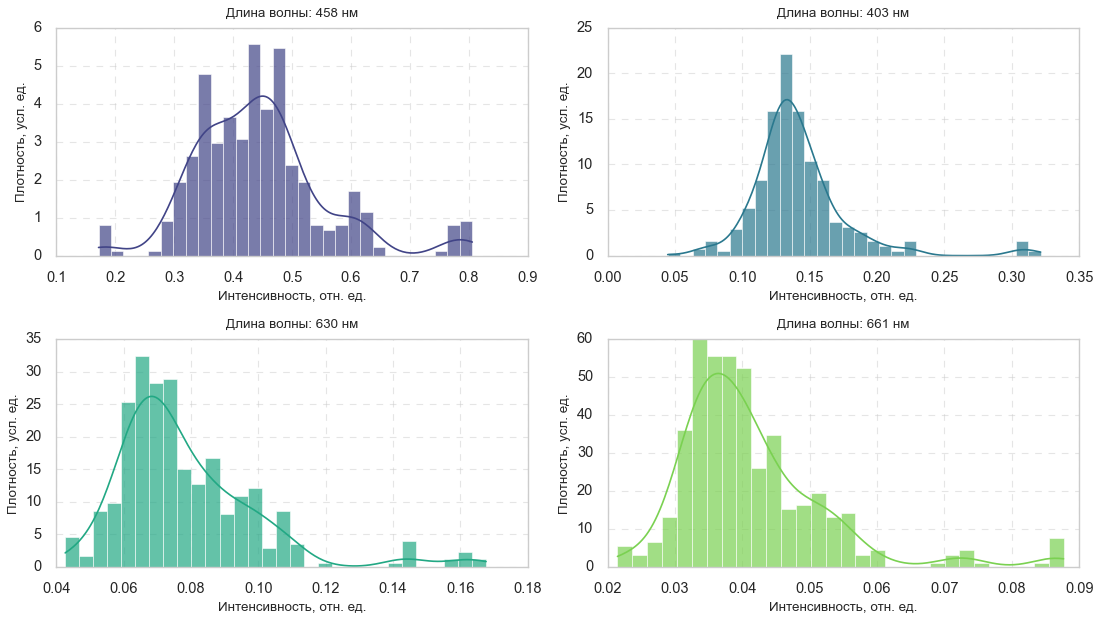

In [99]:
from random import choices
waves = choices(df_dnorm.columns.tolist(), k=4)
plot_intensity_histograms(df_dnorm, waves)

## Отрисовка boxplot

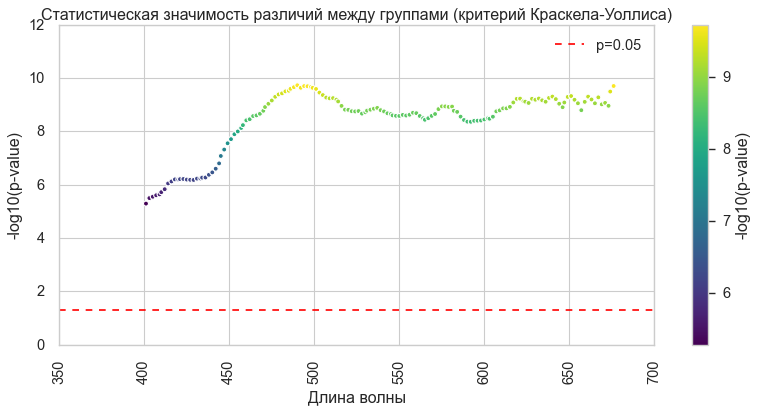

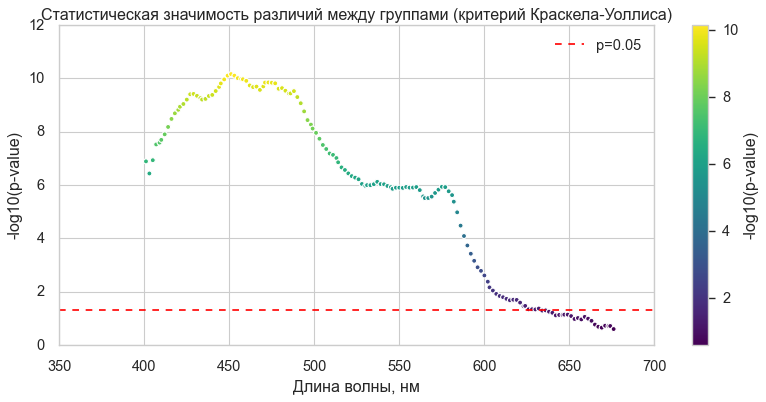

In [160]:
from scipy.stats import kruskal
import numpy as np

# Вычисление p-values для всех длин волн (критерий Краскела-Уоллиса для 3+ групп)
p_values = []
df = df_raw.loc[:, "401":"676"].reset_index(level="GROUP").copy()
for wl in df.columns.drop('GROUP'):
    
    groups = [df[df['GROUP'] == g][wl] for g in df['GROUP'].unique()]
    _, p = kruskal(*groups)
    p_values.append(p)

# Визуализация
plt.figure(figsize=(12, 5))
plt.scatter(x=list(map(func, df.columns.drop('GROUP'))), y=-np.log10(p_values), c=-np.log10(p_values), cmap='viridis')
plt.axhline(-np.log10(0.05), color='red', linestyle='--', label='p=0.05')
plt.colorbar(label='-log10(p-value)')
plt.title('Статистическая значимость различий между группами (критерий Краскела-Уоллиса)')
plt.xlabel('Длина волны')
plt.ylabel('-log10(p-value)')
plt.xticks(rotation=90)
plt.legend()

p_values = []
df = df_dnorm.reset_index(level="GROUP").copy()
for wl in df.columns.drop('GROUP'):
    
    groups = [df[df['GROUP'] == g][wl] for g in df['GROUP'].unique()]
    _, p = kruskal(*groups)
    p_values.append(p)

# Визуализация
plt.figure(figsize=(12, 5))
plt.scatter(x=list(map(func, df.columns.drop('GROUP'))), y=-np.log10(p_values), c=-np.log10(p_values), cmap='viridis')
plt.axhline(-np.log10(0.05), color='red', linestyle='--', label='p=0.05')
plt.colorbar(label='-log10(p-value)')
plt.title('Статистическая значимость различий между группами (критерий Краскела-Уоллиса)')
plt.xlabel('Длина волны, нм')
plt.ylabel('-log10(p-value)')
plt.xticks(rotation=0)
plt.legend()
plt.show()

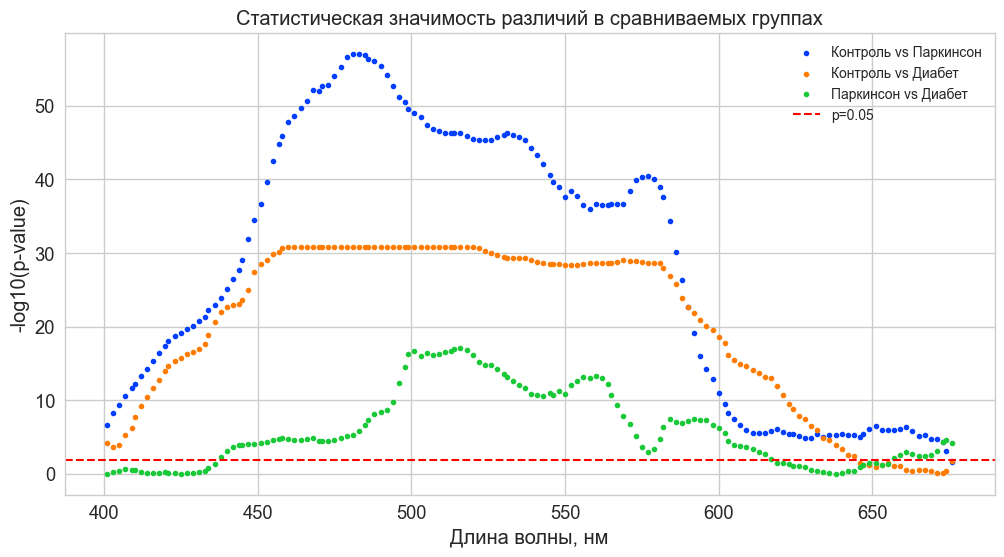

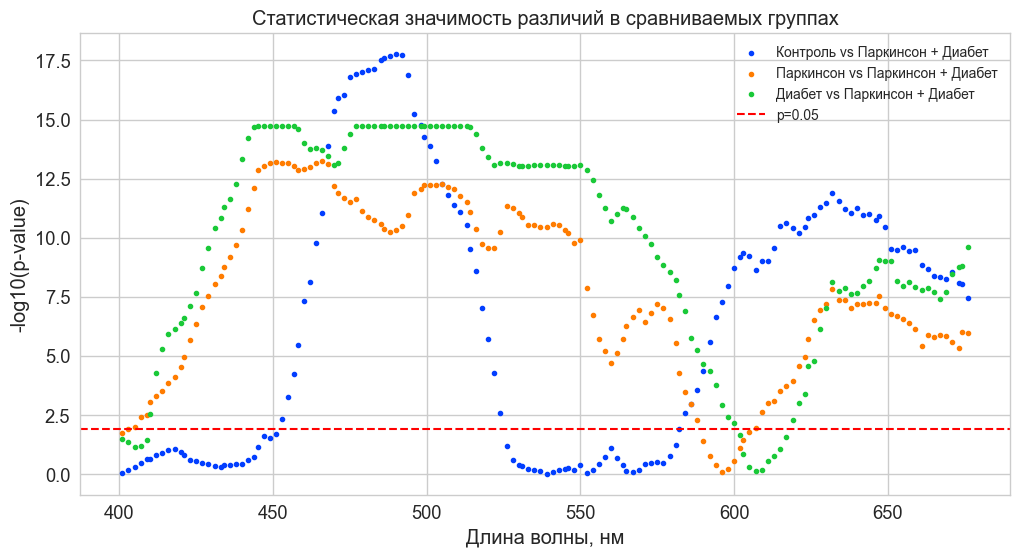

In [457]:
from scipy.stats import mannwhitneyu
import numpy as np

# Вычисление p-values для всех длин волн (критерий Краскела-Уоллиса для 3+ групп)
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("bright")
sns.set_style("whitegrid")
# group_color = {"Control":"#3bc91e", "Diabetes":"#1b3bc9", "Parkinson":"#2ac4c9", }
df = df_inorm.loc[:, "I401":"I676"].reset_index(level="GROUP").copy()
groups = [("Control", "Parkinson"), 
          ("Control", "Diabetes"), 
          ("Parkinson", "Diabetes"), 
          ("Control", "Parkinson + Diabetes"), 
          ("Parkinson", "Parkinson + Diabetes"),
          ("Diabetes", "Parkinson + Diabetes")]
g_names = [("Контроль", "Паркинсон"), 
           ("Контроль", "Диабет"), 
           ("Паркинсон", "Диабет"),
           ("Контроль", "Паркинсон + Диабет"),
           ("Паркинсон", "Паркинсон + Диабет"),
           ("Диабет", "Паркинсон + Диабет")]
plt.figure(figsize=(12, 6))
for i, (g1, g2) in enumerate(groups[:3]):
    p_values = []
    for wl in df.columns.drop('GROUP'):
        
        _, p = mannwhitneyu(df[df["GROUP"] == g1][wl], df[df["GROUP"] == g2][wl])
        p_values.append(p)

    # Визуализация

    plt.scatter(x=list(map(func, df.columns.drop('GROUP'))), y=-np.log10(p_values), linewidths=1, marker=".")
    plt.title(f'Статистическая значимость различий в сравниваемых группах')
    plt.xlabel('Длина волны, нм')
    plt.ylabel('-log10(p-value)')
    plt.xticks(rotation=0)
plt.axhline(-np.log10(0.013), color='red', linestyle='--', label='p=0.05')
groups_1 = [g1 + " vs " + g2 for g1, g2 in g_names][:3]
plt.legend(groups_1 + ['p=0.05'], fontsize=10)


plt.figure(figsize=(12, 6))
j = 3
for i, (g1, g2) in enumerate(groups[3:]):
    p_values = []
    i += j
    for wl in df.columns.drop('GROUP'):
        
        _, p = mannwhitneyu(df[df["GROUP"] == g1][wl], df[df["GROUP"] == g2][wl])
        p_values.append(p)

    # Визуализация

    plt.scatter(x=list(map(func, df.columns.drop('GROUP'))), y=-np.log10(p_values), marker=".")
    plt.title(f'Статистическая значимость различий в сравниваемых группах')
    plt.xlabel('Длина волны, нм')
    plt.ylabel('-log10(p-value)')
    plt.xticks(rotation=0)
plt.axhline(-np.log10(0.013), color='red', linestyle='--', label='p=0.05')
groups_1 = [g1 + " vs " + g2 for g1, g2 in g_names][3:]
plt.legend(groups_1 + ['p=0.05'], fontsize=10)

In [270]:
from scipy.stats import ks_2samp

def compare_spectra_ks(df, group_col='GROUP', group1='Control', group2='Diabetes'):
    results = []
    wavelengths = df.columns.drop(group_col)
    for wl in wavelengths:
        data1 = df[df[group_col] == group1][wl]
        data2 = df[df[group_col] == group2][wl]
        stat, p = ks_2samp(data1, data2)
        results.append({'wavelength': wl, 'statistic': stat, 'p_value': p})
    return pd.DataFrame(results)

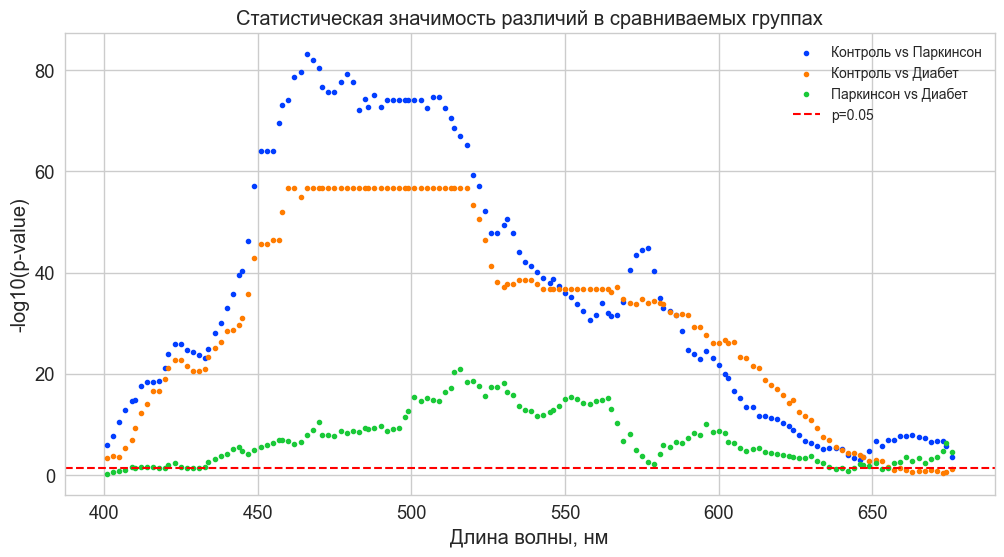

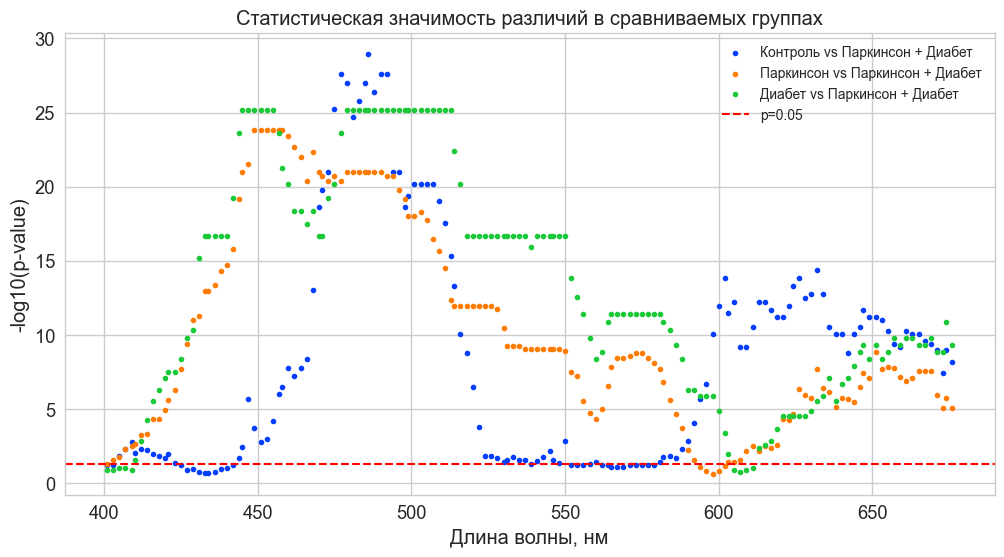

In [459]:
from scipy.stats import mannwhitneyu
import numpy as np

# Вычисление p-values для всех длин волн (критерий Краскела-Уоллиса для 3+ групп)
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("bright")
sns.set_style("whitegrid")
# group_color = {"Control":"#3bc91e", "Diabetes":"#1b3bc9", "Parkinson":"#2ac4c9", }
df = df_inorm.loc[:, "I401":"I676"].reset_index(level="GROUP").copy()
groups = [("Control", "Parkinson"), 
          ("Control", "Diabetes"), 
          ("Parkinson", "Diabetes"), 
          ("Control", "Parkinson + Diabetes"), 
          ("Parkinson", "Parkinson + Diabetes"),
          ("Diabetes", "Parkinson + Diabetes")]
g_names = [("Контроль", "Паркинсон"), 
           ("Контроль", "Диабет"), 
           ("Паркинсон", "Диабет"),
           ("Контроль", "Паркинсон + Диабет"),
           ("Паркинсон", "Паркинсон + Диабет"),
           ("Диабет", "Паркинсон + Диабет")]

plt.figure(figsize=(12, 6))
for i, (g1, g2) in enumerate(groups[:3]):
    p_values = []
    
    res = compare_spectra_ks(df, group1=g1, group2=g2)
    p_values.append(res['p_value'])

    # Визуализация

    plt.scatter(x=list(map(func, df.columns.drop('GROUP'))), y=-np.log10(p_values), marker=".")
    plt.title(f'Статистическая значимость различий в сравниваемых группах')
    plt.xlabel('Длина волны, нм')
    plt.ylabel('-log10(p-value)')
    plt.xticks(rotation=0)
plt.axhline(-np.log10(0.05), color='red', linestyle='--', label='p=0.05')
groups_1 = [g1 + " vs " + g2 for g1, g2 in g_names][:3]
plt.legend(groups_1 + ['p=0.05'], fontsize=10)


plt.figure(figsize=(12, 6))
for i, (g1, g2) in enumerate(groups[3:]):
    p_values = []
    
    res = compare_spectra_ks(df, group1=g1, group2=g2)
    p_values.append(res['p_value'])

    plt.scatter(x=list(map(func, df.columns.drop('GROUP'))), y=-np.log10(p_values), marker=".")
    plt.title(f'Статистическая значимость различий в сравниваемых группах')
    plt.xlabel('Длина волны, нм')
    plt.ylabel('-log10(p-value)')
    plt.xticks(rotation=0)
plt.axhline(-np.log10(0.05), color='red', linestyle='--', label='p=0.05')
groups_1 = [g1 + " vs " + g2 for g1, g2 in g_names][3:]
plt.legend(groups_1 + ['p=0.05'], fontsize=10)


  wavelength                 group  ks_statistic       p_value  is_normal
0       D401               Control      0.979809  1.927486e-02      False
1       D401             Parkinson      0.738359  7.525677e-18      False
2       D401              Diabetes      0.764947  9.330763e-09      False
3       D401  Parkinson + Diabetes      0.969082  8.907118e-01       True
4       D403               Control      0.983696  5.675950e-02       True


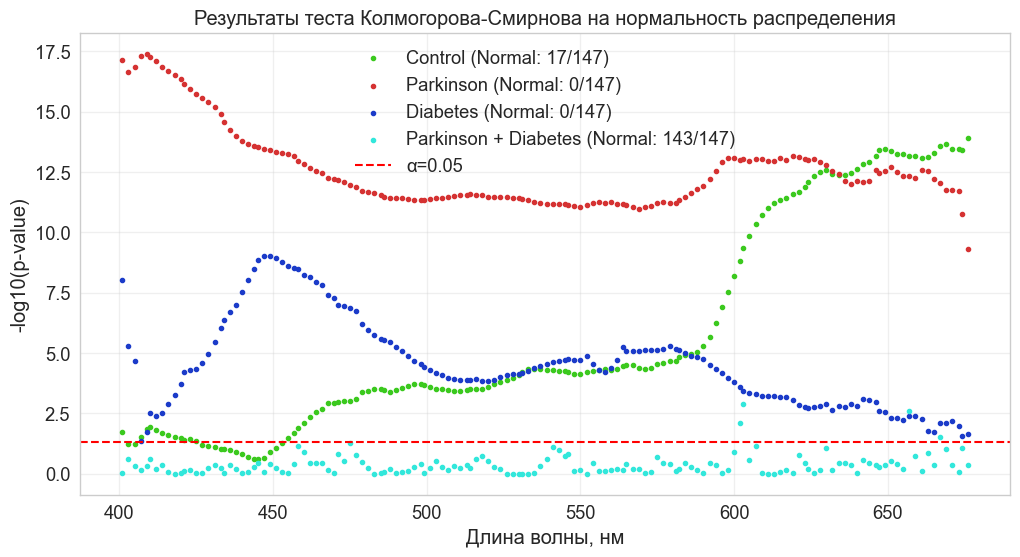

In [291]:
import numpy as np
import pandas as pd
from scipy.stats import kstest, norm, shapiro
import matplotlib.pyplot as plt

def check_normality_ks(data: pd.DataFrame, group_col: str = 'GROUP', alpha: float = 0.05):
    """
    Проверка нормальности распределения интенсивностей для каждой длины волны с помощью теста K-S.
    
    Параметры:
    ----------
    data : pd.DataFrame
        DataFrame с данными спектров (колонки - длины волн, group_col - метки групп)
    group_col : str, optional
        Название колонки с группами (по умолчанию 'group')
    alpha : float, optional
        Уровень значимости (по умолчанию 0.05)
    
    Возвращает:
    ----------
    pd.DataFrame с результатами теста для каждой группы и длины волны
    """
    results = []
    groups = data[group_col].unique()
    
    for wavelength in data.columns.drop(group_col):
        for group in groups:
            # Выборка данных для группы и длины волны
            sample = data[data[group_col] == group][wavelength].values
            
            
            # Проведение теста K-S (сравнение с нормальным распределением)
            stat, p_value = shapiro(sample)
            
            results.append({
                'wavelength': wavelength,
                'group': group,
                'ks_statistic': stat,
                'p_value': p_value,
                'is_normal': p_value > alpha
            })
    
    return pd.DataFrame(results)

# Проверка нормальности
data = df_dnorm.reset_index(level="GROUP")
normality_results = check_normality_ks(data)
print(normality_results.head())
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("coolwarm")
sns.set_style("whitegrid")
# Визуализация результатов
plt.figure(figsize=(12, 6))
group_color = {"Control":"#3bc91e", "Diabetes":"#1b3bc9", "Parkinson":"#d53232", "Parkinson + Diabetes": "#32e7db"}
for group in data['GROUP'].unique():
    group_data = normality_results[normality_results['group'] == group]
    plt.scatter([func(x) for x in group_data['wavelength']], -np.log10(group_data['p_value']), 
               label=f'{group} (Normal: {sum(group_data["is_normal"])}/{len(group_data)})', c=group_color[group], marker=".")


plt.axhline(-np.log10(0.05), color='red', linestyle='--', label='α=0.05')
plt.title('Результаты теста Колмогорова-Смирнова на нормальность распределения')
plt.xlabel('Длина волны, нм')
plt.ylabel('-log10(p-value)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

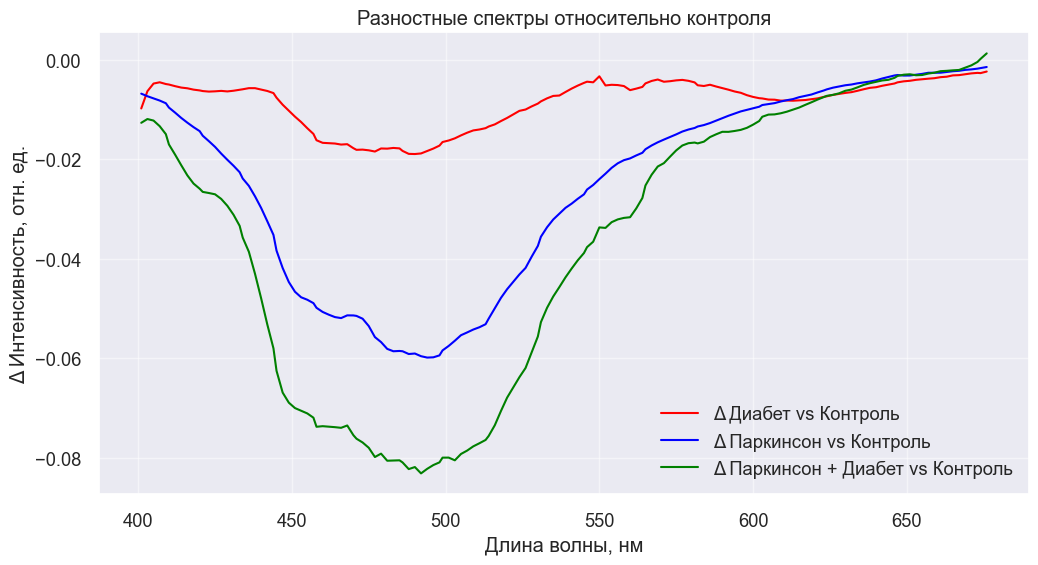

In [446]:
df = df_dnorm.reset_index(level="GROUP").copy()
control_mean = df[df['GROUP'] == 'Control'].mean(numeric_only=True)
diabetes_diff = df[df['GROUP'] == 'Diabetes'].mean(numeric_only=True) - control_mean
parkinson_diff = df[df['GROUP'] == 'Parkinson'].mean(numeric_only=True) - control_mean
park_diab_diff = df[df['GROUP'] == 'Parkinson + Diabetes'].mean(numeric_only=True) - control_mean

x = [func(i) for i in df.columns.drop("GROUP")]
sns.set_style("darkgrid")
plt.figure(figsize=(12, 6))
plt.plot(x, diabetes_diff, label='Δ Диабет vs Контроль', color='red')
plt.plot(x, parkinson_diff, label='Δ Паркинсон vs Контроль', color='blue')
plt.plot(x, park_diab_diff, label='Δ Паркинсон + Диабет vs Контроль', color='green')
#plt.axhline(0, color='black', linestyle='--')
plt.title('Разностные спектры относительно контроля')
plt.xlabel('Длина волны, нм')
plt.ylabel('Δ Интенсивность, отн. ед.')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

## Отрисока Z-оценок

In [243]:
from scipy.stats import shapiro

max = 0
for wave in df_dnorm.columns:
    s, p = shapiro(df_dnorm[wave])
    if p > max:
        max = p
        max_s = s
        wave_max = wave
print(max, max_s, wave)

2.393811962553462e-10 0.9548716792396663 D676


In [176]:
from scipy import stats
def compute_Z(data, start, stop):
    """
        Функция для рассчета Z-оценок по подгруппам Паркинсон, Контроль, Сравнение
        
        data: pd.DataFrame - данные
        start: pd.Index - начало исследуемого участка спектра
        stop: pd.Index - конец исследуемого участка
    """
    Z_cont_park = []
    Z_comp_park = []
    Z_comp_cont = []
    df_cont = data.loc[data.index.get_level_values(level=0) == "Control", start:stop].copy()
    df_park = data.loc[data.index.get_level_values(level=0) == "Parkinson", start:stop].copy()
    df_comp = data.loc[data.index.get_level_values(level=0) == "Comparison", start:stop].copy()
    try:
        preds = [int(val)for val in df_cont.keys()]
    except:
        preds = [int(val[1:])for val in df_cont.keys()]
    
    n1 = len(df_cont)
    n2 = len(df_park)
    mU = n1 * n2 / 2
    sigma_U = (n1 * n2 * (n1 + n2 + 1) / 12) ** 0.5
    for predictor in df_cont.keys():
        U, p = stats.mannwhitneyu(df_cont[predictor], df_park[predictor])
        Z_cont_park.append((float(U) - mU) / sigma_U)
    n1 = len(df_comp)
    n2 = len(df_park)
    mU = n1 * n2 / 2
    sigma_U = (n1 * n2 * (n1 + n2 + 1) / 12) ** 0.5
    for predictor in df_cont.keys():
        U, p = stats.mannwhitneyu(df_comp[predictor], df_park[predictor])
        Z_comp_park.append((float(U) - mU) / sigma_U)
    n1 = len(df_comp)
    n2 = len(df_cont)
    mU = n1 * n2 / 2
    sigma_U = (n1 * n2 * (n1 + n2 + 1) / 12) ** 0.5
    for predictor in df_cont.keys():
        U, p = stats.mannwhitneyu(df_comp[predictor], df_cont[predictor])
        Z_comp_cont.append((float(U) - mU) / sigma_U)
    
    return Z_cont_park, Z_comp_park, Z_comp_cont, preds

In [177]:
from scipy import stats
def compute_z_score(data1: pd.DataFrame, data2: pd.DataFrame):
    Z = []
    n1 = len(data1)
    n2 = len(data2)
    mU = n1 * n2 / 2
    sigma_U = (n1 * n2 * (n1 + n2 + 1) / 12) ** 0.5
    for predictor in data1.keys():
        U, _ = stats.mannwhitneyu(data1[predictor],
                                  data2[predictor])
        Z.append((float(U) - mU) / sigma_U)
    return Z

In [178]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def draw_z(Z, Z_name, preds):
    # Настройка стиля
    plt.style.use('seaborn-v0_8')  # Используем актуальный стиль seaborn
    sns.set_theme(style="whitegrid")  # Альтернативный способ установки стиля
    
    # Создание фигуры с настроенным размером
    plt.figure(figsize=(12, 6), dpi=100)
    
    # Цветовая палитра (используем seaborn)
    colors = sns.color_palette("husl", len(Z))
    
    # Рисуем основные кривые
    for z, name, color in zip(Z, Z_name, colors):
        plt.plot(preds, z, 
                 linewidth=2.5,
                 alpha=0.9,
                 color=color,
                 label=name,
                 marker='o',
                 markersize=4,
                 markeredgecolor='white',
                 markeredgewidth=0.5)
    
    # Критическое значение Z
    
    # Настройка осей и заголовков
    plt.title("I-нормировка", fontsize=16)
    plt.xlabel("Длина волны, нм", fontsize=12, labelpad=10) 
    plt.ylabel("Z оценка, усл. ед.", fontsize=12, labelpad=10)

    
    # Настройка сетки
    plt.grid(True, linestyle=':', alpha=0.7)
    
    # Легенда
    legend = plt.legend(fontsize=10, framealpha=1, 
                       shadow=True, borderpad=1,
                       loc='upper right')
    legend.get_frame().set_facecolor('white')
    
    # Улучшенные пределы осей
    # plt.xlim(min(preds), max(preds))
    # y_max = max(np.max(Z), 2.39) * 1.1  # 10% запас сверху
    # plt.ylim(0, y_max)
    
    # Убираем верхнюю и правую рамку
    sns.despine()
    
    plt.tight_layout()
    plt.show()



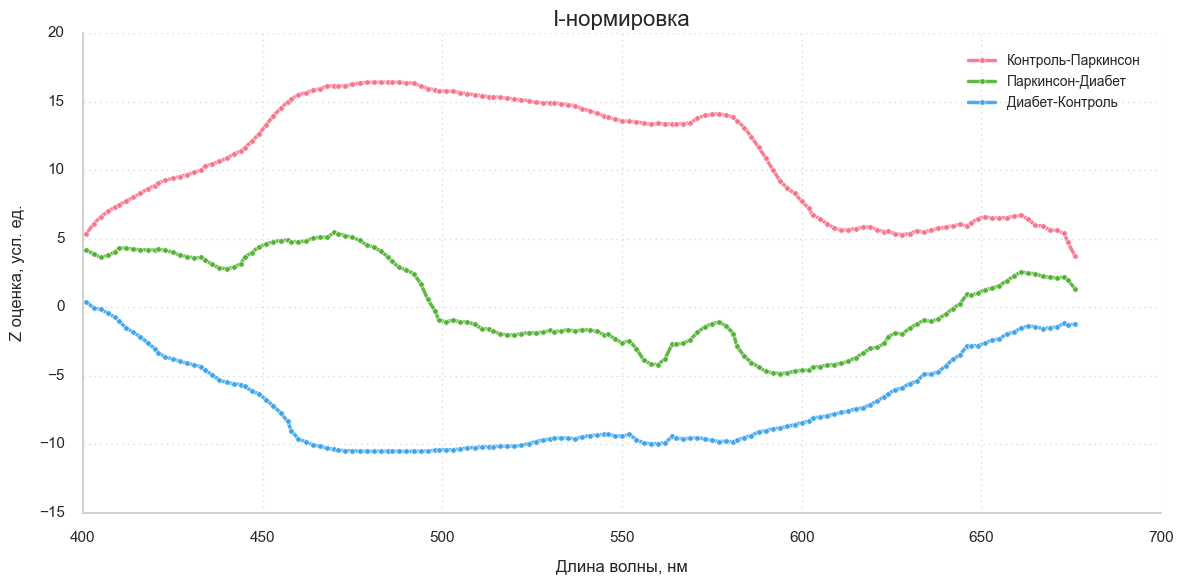

In [183]:
# Пример вызова
Z_cont_park, Z_comp_park, Z_comp_cont, preds = compute_Z(df_inorm, start="I401", stop="I676")
# z = np.array([Z_cont_park, [-z for z in Z_comp_park], [-z for z in Z_comp_cont]])
z = np.array([Z_cont_park, Z_comp_park, Z_comp_cont])
Z_name = ["Контроль-Паркинсон", "Паркинсон-Диабет", "Диабет-Контроль"]
draw_z(z, Z_name, preds)

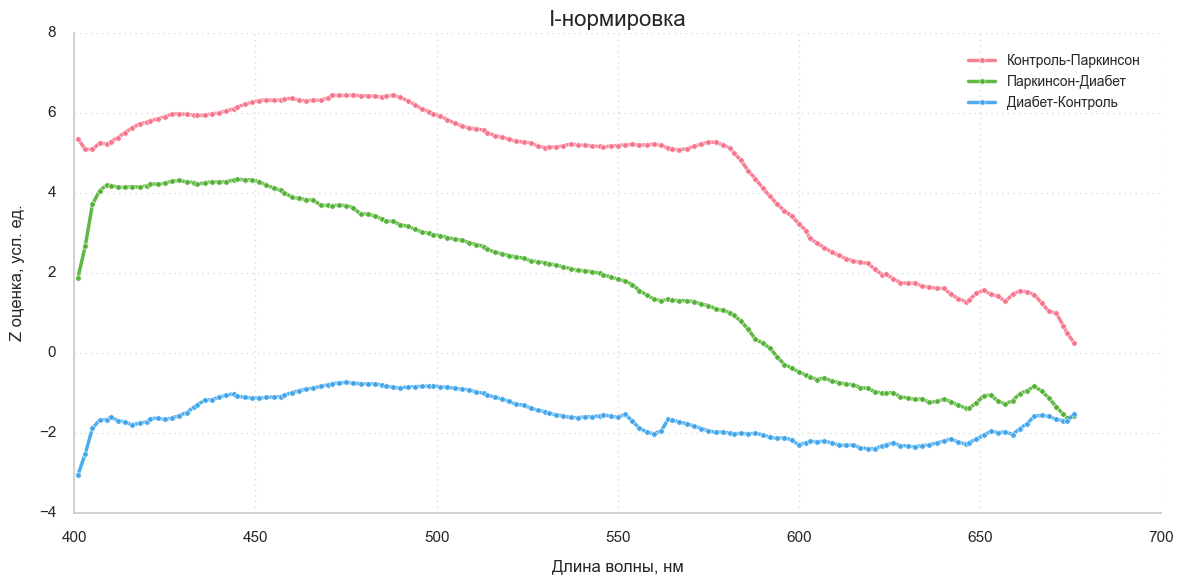

In [182]:
# Пример вызова
Z_cont_park, Z_comp_park, Z_comp_cont, preds = compute_Z(df_dnorm, start="D401", stop="D676")
# z = np.array([Z_cont_park, [-z for z in Z_comp_park], [-z for z in Z_comp_cont]])
z = np.array([Z_cont_park, Z_comp_park, Z_comp_cont])
Z_name = ["Контроль-Паркинсон", "Паркинсон-Диабет", "Диабет-Контроль"]
draw_z(z, Z_name, preds)

## Критерий Фишера

In [197]:
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact
from itertools import combinations

def binarize_spectra(df, group_col='group'):
    """Преобразует спектры в бинарные данные (1 - выше медианы, 0 - ниже)"""
    binary_data = pd.DataFrame()
    groups = df[group_col].unique()
    
    for wavelength in df.columns.drop(group_col):
        for group in groups:
            group_data = df[df[group_col] == group][wavelength]
            median = group_data.median()
            binary_data[f"{wavelength}_{group}"] = (group_data > median).astype(int)
    
    return binary_data

def calculate_fisher_for_spectra(df, group_col='group'):
    """Вычисляет критерий Фишера для всех длин волн между всеми парами групп"""
    groups = df[group_col].unique()
    group_pairs = list(combinations(groups, 2))
    results = {}
    
    for wavelength in df.columns.drop(group_col):
        wavelength_results = {}
        
        for g1, g2 in group_pairs:
            # Получаем данные для двух групп
            data_g1 = df[df[group_col] == g1][wavelength]
            data_g2 = df[df[group_col] == g2][wavelength]
            
            # Бинаризуем относительно общей медианы
            combined_median = pd.concat([data_g1, data_g2]).median()
            table = np.array([
                [(data_g1 > combined_median).sum(), (data_g1 <= combined_median).sum()],
                [(data_g2 > combined_median).sum(), (data_g2 <= combined_median).sum()]
            ])
            
            # Вычисляем критерий Фишера
            odds_ratio, p_value = fisher_exact(table)
            wavelength_results[f"{g1}_vs_{g2}"] = {
                'odds_ratio': odds_ratio,
                'p_value': p_value,
                'table': table
            }
        
        results[wavelength] = wavelength_results
    
    return pd.DataFrame.from_dict({(i,j): results[i][j] 
                                 for i in results.keys() 
                                 for j in results[i].keys()}, 
                                orient='index')

# Пример использования
# Предполагаем, что данные в формате: колонки - длины волн, плюс колонка 'group' с метками групп
data = pd.DataFrame({
    'group': ['A']*10 + ['B']*10 + ['C']*10,
    '500nm': np.concatenate([np.random.normal(100, 10, 10),
                            np.random.normal(110, 15, 10),
                            np.random.normal(90, 12, 10)]),
    '600nm': np.concatenate([np.random.normal(200, 20, 10),
                            np.random.normal(180, 25, 10),
                            np.random.normal(220, 18, 10)])
})



In [157]:
import pandas as pd
from itertools import combinations
import numpy as np
from scipy.stats import fisher_exact

def fisher_to_z(table):
    """Преобразует результат точного критерия Фишера в Z-подобную статистику"""
    odds_ratio, p_value = fisher_exact(table)
    
    # Логарифмированное отношение шансов (аналог эффекта)
    log_or = np.log(odds_ratio)
    
    # Стандартная ошибка (приближенная)
    a, b, c, d = table.ravel()
    se_log_or = np.sqrt(1/a + 1/b + 1/c + 1/d)
    
    # Z-подобная статистика
    z = log_or / se_log_or if se_log_or != 0 else 0
    
    return z, log_or, se_log_or, odds_ratio, p_value

def calculate_fisher_z_for_spectra(df, group_col='group'):
    """Вычисляет Z-подобные статистики для всех длин волн"""
    groups = df[group_col].unique()
    group_pairs = list(combinations(groups, 2))
    results = []
    
    for wavelength in df.columns.drop(group_col):
        for g1, g2 in group_pairs:
            # Подготовка данных
            data_g1 = df[df[group_col] == g1][wavelength]
            data_g2 = df[df[group_col] == g2][wavelength]
            
            # Бинаризация относительно общей медианы
            combined_median = pd.concat([data_g1, data_g2]).median()
            table = np.array([
                [(data_g1 > combined_median).sum(), (data_g1 <= combined_median).sum()],
                [(data_g2 > combined_median).sum(), (data_g2 <= combined_median).sum()]
            ])
            
            # Вычисление статистик
            z, log_or, se, or_, p = fisher_to_z(table)
            
            results.append({
                'wavelength': wavelength,
                'comparison': f"{g1}_vs_{g2}",
                'z_score': z,
                'log_or': log_or,
                'se_log_or': se,
                'odds_ratio': or_,
                'p_value': p
            })
    
    return pd.DataFrame(results)

# Пример данных (как в предыдущем вопросе)
data = pd.DataFrame({
    'group': ['A']*10 + ['B']*10 + ['C']*10,
    '500nm': np.concatenate([np.random.normal(100, 10, 10),
                            np.random.normal(110, 15, 10),
                            np.random.normal(90, 12, 10)]),
    '600nm': np.concatenate([np.random.normal(200, 20, 10),
                            np.random.normal(180, 25, 10),
                            np.random.normal(220, 18, 10)])
})



C:\Users\nikba\AppData\Local\Temp\ipykernel_6504\46022744.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  se_log_or = np.sqrt(1/a + 1/b + 1/c + 1/d)
C:\Users\nikba\AppData\Local\Temp\ipykernel_6504\46022744.py:18: RuntimeWarning: invalid value encountered in scalar divide
  z = log_or / se_log_or if se_log_or != 0 else 0
C:\Users\nikba\AppData\Local\Temp\ipykernel_6504\46022744.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  se_log_or = np.sqrt(1/a + 1/b + 1/c + 1/d)
C:\Users\nikba\AppData\Local\Temp\ipykernel_6504\46022744.py:18: RuntimeWarning: invalid value encountered in scalar divide
  z = log_or / se_log_or if se_log_or != 0 else 0
C:\Users\nikba\AppData\Local\Temp\ipykernel_6504\46022744.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  se_log_or = np.sqrt(1/a + 1/b + 1/c + 1/d)
C:\Users\nikba\AppData\Local\Temp\ipykernel_6504\46022744.py:18: RuntimeWarning: invalid value encountered in scalar divide
  z = log_or / se_

    wavelength            comparison   z_score    log_or  se_log_or  \
0         I401  Control_vs_Parkinson  3.552598  0.761459   0.214339   
3         I403  Control_vs_Parkinson  5.782621  1.282956   0.221864   
6         I405  Control_vs_Parkinson  6.373189  1.432525   0.224774   
9         I407  Control_vs_Parkinson  6.761345  1.534541   0.226958   
12        I409  Control_vs_Parkinson  7.521981  1.745041   0.231992   
..         ...                   ...       ...       ...        ...   
426       I669  Control_vs_Parkinson  5.183385  1.136992   0.219353   
429       I671  Control_vs_Parkinson  4.779737  1.041416   0.217881   
432       I673  Control_vs_Parkinson  4.779737  1.041416   0.217881   
435       I674  Control_vs_Parkinson  4.779737  1.041416   0.217881   
438       I676  Control_vs_Parkinson  3.552598  0.761459   0.214339   

     odds_ratio       p_value  
0      2.141398  5.023055e-04  
3      3.607287  5.517066e-09  
6      4.189265  9.178578e-11  
9      4.639197  4.

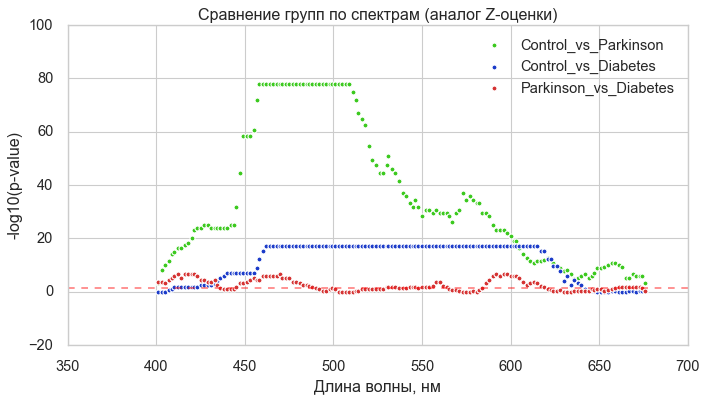

In [215]:
# Расчет статистик
fisher_z_results = calculate_fisher_z_for_spectra(df_inorm.reset_index(level="GROUP"), group_col="GROUP")

# Визуализация Z-статистик
import matplotlib.pyplot as plt
 
colors = {"Control_vs_Parkinson":"#3bc91e", "Control_vs_Diabetes":"#1b3bc9", "Parkinson_vs_Diabetes":"#d53232"}

plt.figure(figsize=(10, 5))
for comp in fisher_z_results['comparison'].unique():
    comp_data = fisher_z_results[fisher_z_results['comparison'] == comp]
    print(comp_data)
    wavelength = [int(x[1:]) if x[0] in ["D", "I"] else int(x) for x in comp_data['wavelength'].to_list()]
    plt.scatter(wavelength, -np.log10(comp_data['p_value'].to_numpy()), label=comp, c=colors[comp])

plt.axhline(-np.log10(0.05), linestyle='--', color='red', alpha=0.5)  # Уровень значимости ~0.05
# plt.axhline(np.log10(0.05), linestyle='--', color='red', alpha=0.5)
plt.xlabel('Длина волны, нм')
plt.ylabel('-log10(p-value)')
plt.title('Сравнение групп по спектрам (аналог Z-оценки)')
plt.legend()
plt.show()

In [ ]:
# Вычисляем статистики Фишера
fisher_results = calculate_fisher_for_spectra(df_inorm.reset_index(level="GROUP"), group_col="GROUP")

# Выводим результаты
print("Результаты попарных сравнений для каждой длины волны:")
print(fisher_results.head())

# Можно отфильтровать значимые результаты (p < 0.05)
significant_results = fisher_results[fisher_results['p_value'] < 0.05]
print("\nСтатистически значимые различия (p < 0.05):")
print(significant_results)

Результаты попарных сравнений для каждой длины волны:
                              odds_ratio       p_value                   table
I401 Control_vs_Parkinson       2.141398  5.023055e-04   [[97, 63], [87, 121]]
     Control_vs_Comparison      0.897284  8.694212e-01    [[79, 81], [25, 23]]
     Parkinson_vs_Comparison    0.264368  1.828546e-04   [[92, 116], [36, 12]]
I403 Control_vs_Parkinson       3.607287  5.517066e-09  [[108, 52], [76, 132]]
     Control_vs_Comparison      1.114474  8.694212e-01    [[81, 79], [23, 25]]

Статистически значимые различия (p < 0.05):
                              odds_ratio       p_value                   table
I401 Control_vs_Parkinson       2.141398  5.023055e-04   [[97, 63], [87, 121]]
     Parkinson_vs_Comparison    0.264368  1.828546e-04   [[92, 116], [36, 12]]
I403 Control_vs_Parkinson       3.607287  5.517066e-09  [[108, 52], [76, 132]]
     Parkinson_vs_Comparison    0.264368  1.828546e-04   [[92, 116], [36, 12]]
I405 Control_vs_Parkinson       